# **Implementation of the Noisy Student Training method on MNIST dataset**

## **Etienne Gaucher**




# 1 - Importing libraries and checking GPU availability


In [1]:
# Import libraries
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import Counter
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

In [2]:
# Check GPU availability
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda:0 device


# 2 - Loading MNIST dataset

In [3]:
# Normalize images in the range [-1, 1]
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])

# Load MNIST training dataset
training_data = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

# Load MNIST test dataset
test_data = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
# training_data = 60 000 images of 28 x 28 pixels
print("training_data shape:", training_data.data.shape, "\n")

# test_data = 10 000 images of 28 x 28 pixels
print("test_data shape:", test_data.data.shape)

training_data shape: torch.Size([60000, 28, 28]) 

test_data shape: torch.Size([10000, 28, 28])


In [5]:
# Number of images per class and proportion
counter = sorted(Counter(training_data.targets.tolist()).items())
print("Number of images per class:", counter, "\n")
print("Proportion per class:", [(x, round(y/len(training_data), 3)) for (x,y) in counter])

Number of images per class: [(0, 5923), (1, 6742), (2, 5958), (3, 6131), (4, 5842), (5, 5421), (6, 5918), (7, 6265), (8, 5851), (9, 5949)] 

Proportion per class: [(0, 0.099), (1, 0.112), (2, 0.099), (3, 0.102), (4, 0.097), (5, 0.09), (6, 0.099), (7, 0.104), (8, 0.098), (9, 0.099)]


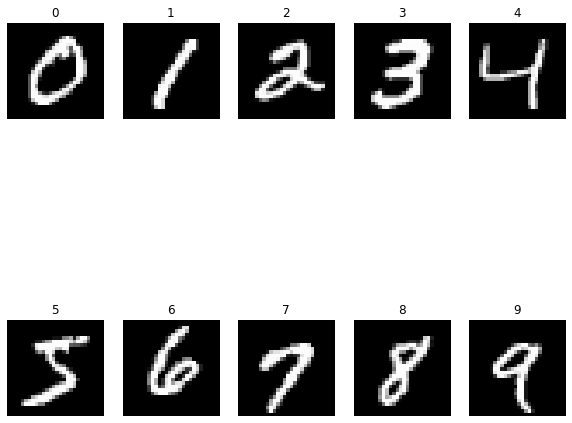

In [6]:
# One sample for every class
figure = plt.figure(figsize=(10, 10))
idx = [1, 3, 5, 7, 2, 0, 13, 15, 17, 4]
for i in range(1, 11):
    sample_idx = idx[i-1]
    img, label = training_data[sample_idx]
    figure.add_subplot(2, 5, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# 3 - Datasets building

### Splitting training_data into trainset (training dataset) and valset (validation dataset)

In [40]:
random_state = 42

# Generate random indices for training and validation datasets
train_indices, val_indices = train_test_split(list(range(len(training_data.targets))), test_size=10000, stratify=training_data.targets, random_state=random_state)

# Validation dataset = subset of training_data at val_indices
valset = torch.utils.data.Subset(training_data, val_indices)

# Training dataset = subset of training_data at train_indices
trainset = torch.utils.data.Subset(training_data, train_indices)

In [25]:
# Check of the split
print("valset size:", len(valset), "\n")
valset_label = [valset[i][1] for i in range(len(valset))]
valset_counter = sorted(Counter(valset_label).items())
print("Number of images per class in valset:", valset_counter)

valset size: 10000 

Number of images per class in valset: [(0, 987), (1, 1124), (2, 993), (3, 1022), (4, 974), (5, 903), (6, 986), (7, 1044), (8, 975), (9, 992)]


### Splitting trainset into labelset (labeled dataset) and unlabelset (unlabeled dataset)

In [41]:
# Generate random indices for labeled and unlabeled datasets
unlabel_indices, label_indices = train_test_split(train_indices, test_size=100, stratify=training_data.targets[train_indices], random_state=random_state)

# Unlabeled dataset = subset of training_data at unlabel_indices
unlabelset = torch.utils.data.Subset(training_data, unlabel_indices)

# Labeled dataset = subset of training_data at label_indices
labelset = torch.utils.data.Subset(training_data, label_indices)

In [10]:
# Check of the split
print("labelset size:", len(labelset), "\n")
labelset_label = [labelset[i][1] for i in range(len(labelset))]
labelset_counter = sorted(Counter(labelset_label).items())
print("Number of images per class in labelset:", labelset_counter, "\n")

print("unlabelset size: ", len(unlabelset), "\n")
unlabelset_label = [unlabelset[i][1] for i in range(len(unlabelset))]
unlabelset_counter = sorted(Counter(unlabelset_label).items())
print("Number of images per class in unlabelset:", unlabelset_counter)

labelset size: 100 

Number of images per class in labelset: [(0, 10), (1, 11), (2, 10), (3, 10), (4, 10), (5, 9), (6, 10), (7, 10), (8, 10), (9, 10)] 

unlabelset size:  49900 

Number of images per class in unlabelset: [(0, 4926), (1, 5607), (2, 4955), (3, 5099), (4, 4858), (5, 4509), (6, 4922), (7, 5211), (8, 4866), (9, 4947)]


### Creating dataloaders

In [42]:
# Dataloader of the labeled dataset
labelloader = torch.utils.data.DataLoader(labelset, batch_size=1,
                                          shuffle=False, num_workers=2)

# Dataloader of the unlabeled dataset
unlabelloader = torch.utils.data.DataLoader(unlabelset, batch_size=64,
                                            shuffle=False, num_workers=2)

# Dataloader of the validation dataset
valloader = torch.utils.data.DataLoader(valset, batch_size=64,
                                        shuffle=False, num_workers=2)

# Dataloader of the training dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=False, num_workers=2)

# Dataloader of the test dataset
testloader = torch.utils.data.DataLoader(test_data, batch_size=64,
                                         shuffle=False, num_workers=2)

# 4 - Implementation of the neural networks

### Implementation of the teacher model (unnoised neural network)

In [43]:
class Teacher(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding="same")
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same")
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(in_features=32 * 14 * 14, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

teacher = Teacher().to(device)

### Implementation of the student model (noised with dropout)

In [44]:
class Student(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding="same")
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same")
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.dp = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(in_features=32 * 14 * 14, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.dp(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

student = Student().to(device)

### Set the last-layer activation, loss function, optimizer and metric

In [45]:
# Last-layer activation = softmax activation
output_fn = torch.nn.Softmax(dim=1)

# Loss function = cross entropy loss
criterion = nn.CrossEntropyLoss()

# Optimizer = Adam optimization
optimizer = optim.Adam(teacher.parameters(), lr=0.001)

# Metric = accuracy
def get_accuracy(y_true, y_pred):
    return int(np.sum(np.equal(y_true, y_pred))) / y_true.shape[0]

# 5 - Early stopping implementation


In [15]:
### EARLY STOPPING PARAMETERS
# Number of epochs with no improvement of the validation loss after which training will be stopped
patience = 5
# Minimum change in the validation loss to qualify as an improvement
delta = 0
# Initialize number of epochs with no improvement 
epoch_no_improve = 0
# Initialize minimum validation loss
min_val_loss = 10

# Maximum number of epochs to train the model
epochs = 25


# Initialize lists monitoring validation loss and validation accuracy for every epoch
loss_valid, acc_valid = [], []
# Initialize lists monitoring training loss and training accuracy for every epoch 
loss_train, acc_train = [], []


for epoch in tqdm(range(epochs)):

  ### TRAINING
  teacher.train()
  for idx, batch in enumerate(labelloader):

    # Get inputs and labels of the batch
    inputs, labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Set gradients to zero
    optimizer.zero_grad()

    # Forward
    out = teacher(x=inputs)
    loss = criterion(out, labels)

    # Backward
    loss.backward()

    # Optimization step
    optimizer.step()


	### COMPUTE VALIDATION LOSS AND VALIDATION ACCURACY
  teacher.eval()
  with torch.no_grad():
    idx = 0
    for batch in valloader:

      # Get inputs and labels of the batch
      inputs, labels = batch
      inputs = inputs.to(device)
      labels = labels.to(device)

      if idx==0:
        # Get outputs of the model
        t_out = teacher(x=inputs)
        # Compute batch loss
        t_loss = criterion(t_out, labels).view(1).item()
        # Class predictions
        t_out = output_fn(t_out).detach().cpu().numpy()
        t_out = t_out.argmax(axis=1)
        # Labels                
        ground_truth = labels.detach().cpu().numpy()
      
      else:
        # Get outputs of the model
        out = teacher(x=inputs)
        # Compute and add batch loss
        t_loss = np.hstack((t_loss, criterion(out, labels).item()))
        # Add class predictions
        t_out = np.hstack((t_out, output_fn(out).argmax(axis=1).detach().cpu().numpy()))
        # Add labels
        ground_truth = np.hstack((ground_truth, labels.detach().cpu().numpy()))

      idx+=1

    # Add validation accuracy to acc_valid
    acc_valid.append(get_accuracy(ground_truth, t_out))
    # Add validation loss to loss_valid
    loss_valid.append(np.mean(t_loss))
    

    ### EARLY STOPPING IMPLEMENTATION
    # Check if validation loss has improved
    if np.mean(t_loss) < (min_val_loss - delta):
      epoch_no_improve = 0
      # Set new minimum validation loss
      min_val_loss = np.mean(t_loss)
      # Save model
      torch.save(teacher.state_dict(), 'net.pth')
      print('\nSaving model... \n')
    
    else:
      epoch_no_improve += 1


  ### COMPUTE TRAINING LOSS AND TRAINING ACCURACY
  with torch.no_grad():
    idx = 0
    for batch in labelloader:

      # Get inputs and labels of the batch
      inputs, labels = batch
      inputs = inputs.to(device)
      labels = labels.to(device)

      if idx==0:
        # Get outputs of the model
        t_out = teacher(x=inputs)
        # Compute batch loss
        t_loss = criterion(t_out, labels).view(1).item()
        # Class predictions
        t_out = output_fn(t_out).detach().cpu().numpy()
        t_out = t_out.argmax(axis=1)
        # Labels
        ground_truth = labels.detach().cpu().numpy()

      else:
        # Get outputs of the model
        out = teacher(x=inputs)
        # Compute and add batch loss
        t_loss = np.hstack((t_loss, criterion(out, labels).item()))
        # Add class predictions
        t_out = np.hstack((t_out, output_fn(out).argmax(axis=1).detach().cpu().numpy()))
        # Add labels
        ground_truth = np.hstack((ground_truth, labels.detach().cpu().numpy()))
        
      idx+=1

    # Add training accuracy to acc_train
    acc_train.append(get_accuracy(ground_truth, t_out))
    # Add training loss to loss_train
    loss_train.append(np.mean(t_loss))
    

  print('| Epoch: {}/{} | Train: Loss {:.4f} Accuracy : {:.4f} '\
      '| Val: Loss {:.4f} Accuracy : {:.4f}\n'.format(epoch+1, epochs, loss_train[epoch], acc_train[epoch], loss_valid[epoch], acc_valid[epoch]))


  ### STOP TRAINING CONDITION
  if epoch_no_improve == patience:
    break

  0%|          | 0/25 [00:00<?, ?it/s]


Saving model... 



  4%|▍         | 1/25 [00:10<04:02, 10.09s/it]

| Epoch: 1/25 | Train: Loss 1.1135 Accuracy : 0.6700 | Val: Loss 1.4394 Accuracy : 0.5603


Saving model... 



  8%|▊         | 2/25 [00:12<02:13,  5.79s/it]

| Epoch: 2/25 | Train: Loss 0.3218 Accuracy : 0.8800 | Val: Loss 1.0522 Accuracy : 0.7011


Saving model... 



 12%|█▏        | 3/25 [00:15<01:37,  4.45s/it]

| Epoch: 3/25 | Train: Loss 0.1659 Accuracy : 0.9400 | Val: Loss 0.9133 Accuracy : 0.7415


Saving model... 



 16%|█▌        | 4/25 [00:18<01:19,  3.79s/it]

| Epoch: 4/25 | Train: Loss 0.0488 Accuracy : 0.9900 | Val: Loss 0.8516 Accuracy : 0.7772



 20%|██        | 5/25 [00:21<01:12,  3.63s/it]

| Epoch: 5/25 | Train: Loss 0.0715 Accuracy : 0.9800 | Val: Loss 0.8881 Accuracy : 0.7600



 24%|██▍       | 6/25 [00:24<01:03,  3.32s/it]

| Epoch: 6/25 | Train: Loss 0.0794 Accuracy : 0.9800 | Val: Loss 1.3455 Accuracy : 0.7352



 28%|██▊       | 7/25 [00:27<00:56,  3.15s/it]

| Epoch: 7/25 | Train: Loss 0.0077 Accuracy : 1.0000 | Val: Loss 1.1076 Accuracy : 0.7659



 32%|███▏      | 8/25 [00:30<00:51,  3.01s/it]

| Epoch: 8/25 | Train: Loss 0.0105 Accuracy : 1.0000 | Val: Loss 1.2023 Accuracy : 0.7529



 32%|███▏      | 8/25 [00:33<01:11,  4.22s/it]

| Epoch: 9/25 | Train: Loss 0.0017 Accuracy : 1.0000 | Val: Loss 1.0702 Accuracy : 0.7867



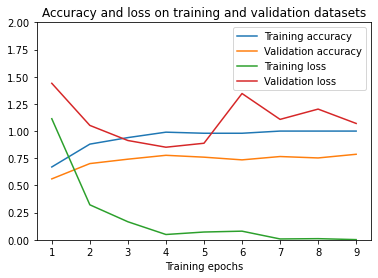

In [16]:
# Plotting training accuracy, training loss, validation accuracy and validation loss
epochs = epoch + 2
plt.title("Accuracy and loss on training and validation datasets")
plt.xlabel("Training epochs")
plt.plot(range(1, epochs), acc_train, label="Training accuracy")
plt.plot(range(1, epochs), acc_valid, label="Validation accuracy")
plt.plot(range(1, epochs), loss_train, label="Training loss")
plt.plot(range(1, epochs), loss_valid, label="Validation loss")
plt.ylim((0,2.))
plt.xticks(np.arange(1, epochs, 1.0))
plt.legend()
plt.show()

# 6 - Implementation of the Noisy Student Training method

In [17]:
def weight_reset(model):
  """
  Reset all parameters of a model
  :param model [nn.Module]: neural network model
  """
  if isinstance(model, nn.Conv2d) or isinstance(model, nn.Linear):
    model.reset_parameters()

In [46]:
def noisy_student(student_class, data_augmentation):
  """
  Implement the Noisy Student Training method
  :param student_network [nn.Module]: neural network class of the student, in {Teacher(), Student()}
  :param data_augmentation [bool]: whether to add data augmentation to the labeled and unlabeled datasets when training student model
  :return: print training process
  """

  ### EARLY STOPPING PARAMETERS FOR TRAINING A MODEL
  # Number of epochs with no improvement of the validation loss after which training will be stopped
  patience = 4
  # Minimum change in the validation loss to qualify as an improvement
  delta = 0
  # Initialize number of epochs with no improvement 
  epoch_no_improve = 0
  # Initialize minimum validation loss
  min_val_loss = 10

  # Maximum number of epochs to train a model
  epochs = 25


  ### EARLY STOPPING PARAMETERS FOR LOOP TEACHER-STUDENT
  # Number of iterations with no improvement of the validation loss after which loop will be stopped
  patience_repeat = 3
  # Initialize number of iterations with no improvement 
  repeat_no_improve = 0
  # Initialize minimum validation loss
  min_val_loss_repeat = 10

  # Maximum number of iterations for loop teacher-student
  repeat = 10


  # Initialize lists monitoring validation loss and validation accuracy for every epoch
  loss_valid, acc_valid = [], []
  # Initialize lists monitoring training loss and training accuracy for every epoch 
  loss_train, acc_train = [], []


  # Create the teacher model
  teacher = Teacher().to(device)
  # Set the optimizer
  optimizer = optim.Adam(teacher.parameters(), lr=0.001)


  ### TRAIN THE TEACHER MODEL ON THE LABELED DATASET WITH EARLY STOPPING
  for epoch in tqdm(range(epochs)):

    ### TRAINING
    teacher.train()
    for idx, batch in enumerate(labelloader):

      # Get inputs and labels of the batch
      inputs, labels = batch
      inputs = inputs.to(device)
      labels = labels.to(device)

      # Set gradients to zero
      optimizer.zero_grad()

      # Forward
      out = teacher(x=inputs)
      loss = criterion(out, labels)

      # Backward
      loss.backward()

      # Optimization step
      optimizer.step()


    ### COMPUTE VALIDATION LOSS AND VALIDATION ACCURACY
    teacher.eval()
    with torch.no_grad():
      idx = 0
      for batch in valloader:

        # Get inputs and labels of the batch
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        if idx==0:
          # Get outputs of the model
          t_out = teacher(x=inputs)
          # Compute batch loss
          t_loss = criterion(t_out, labels).view(1).item()
          # Class predictions
          t_out = output_fn(t_out).detach().cpu().numpy()
          t_out = t_out.argmax(axis=1)
          # Labels
          ground_truth = labels.detach().cpu().numpy()

        else:
          # Get outputs of the model
          out = teacher(x=inputs)
          # Compute and add batch loss
          t_loss = np.hstack((t_loss, criterion(out, labels).item()))
          # Add class predictions
          t_out = np.hstack((t_out, output_fn(out).argmax(axis=1).detach().cpu().numpy()))
          # Add labels
          ground_truth = np.hstack((ground_truth, labels.detach().cpu().numpy()))

        idx+=1

      # Add validation accuracy to acc_valid
      acc_valid.append(get_accuracy(ground_truth, t_out))
      # Add validation loss to loss_valid
      loss_valid.append(np.mean(t_loss))
      

      ### EARLY STOPPING IMPLEMENTATION
      # Check if validation loss has improved
      if np.mean(t_loss) < (min_val_loss - delta):
        epoch_no_improve = 0
        # Set new minimum validation loss
        min_val_loss = np.mean(t_loss)
        # Save model
        torch.save(teacher.state_dict(), 'net.pth')
        print('\nSaving model... \n')
      
      else:
        epoch_no_improve += 1


    ### COMPUTE TRAINING LOSS AND TRAINING ACCURACY
    with torch.no_grad():
      idx = 0
      for batch in labelloader:

        # Get inputs and labels of the batch
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        if idx==0:
          # Get outputs of the model
          t_out = teacher(x=inputs)
          # Compute batch loss
          t_loss = criterion(t_out, labels).view(1).item()
          # Class predictions
          t_out = output_fn(t_out).detach().cpu().numpy()
          t_out = t_out.argmax(axis=1)
          # Labels
          ground_truth = labels.detach().cpu().numpy()

        else:
          # Get outputs of the model
          out = teacher(x=inputs)
          # Compute and add batch loss
          t_loss = np.hstack((t_loss, criterion(out, labels).item()))
          # Add class predictions
          t_out = np.hstack((t_out, output_fn(out).argmax(axis=1).detach().cpu().numpy()))
          # Add labels  
          ground_truth = np.hstack((ground_truth, labels.detach().cpu().numpy()))

        idx+=1

      # Add training accuracy to acc_train
      acc_train.append(get_accuracy(ground_truth, t_out))
      # Add training loss to loss_train
      loss_train.append(np.mean(t_loss))


    print('| Epoch: {}/{} | Train: Loss {:.4f} Accuracy : {:.4f} '\
        '| Val: Loss {:.4f} Accuracy : {:.4f}\n'.format(epoch+1, epochs, loss_train[epoch], acc_train[epoch], loss_valid[epoch], acc_valid[epoch]))


    ### STOP TRAINING CONDITION
    if epoch_no_improve == patience:
      break


  ### LOAD THE TEACHER MODEL WITH THE LOWEST VALIDATION LOSS
  teacher = Teacher().to(device)
  teacher.load_state_dict(torch.load('net.pth'))


  ### COMPUTE THE BASELINE ON THE TEST DATASET
  teacher.eval()
  with torch.no_grad():
    idx = 0
    for batch in testloader:

      # Get inputs and labels of the batch
      inputs, labels = batch
      inputs = inputs.to(device)
      labels = labels.to(device)

      if idx==0:
        # Get outputs of the model
        t_out = teacher(x=inputs)
        # Class predictions
        t_out = output_fn(t_out).detach().cpu().numpy()
        t_out = t_out.argmax(axis=1)
        # Labels
        ground_truth = labels.detach().cpu().numpy()

      else:
        # Get outputs of the model
        out = teacher(x=inputs)
        # Add class predictions
        t_out = np.hstack((t_out, output_fn(out).argmax(axis=1).detach().cpu().numpy()))
        # Add labels
        ground_truth = np.hstack((ground_truth, labels.detach().cpu().numpy()))

      idx+=1

  print('Baseline accuracy:', get_accuracy(ground_truth, t_out), '\n')


  ### USE THE TEACHER MODEL TO GENERATE PSEUDO LABELS ON THE UNLABELED DATASET
  with torch.no_grad():
    idx = 0
    for batch in unlabelloader:

      # Get inputs and labels of the batch
      inputs, labels = batch
      inputs = inputs.to(device)

      if idx==0:
        # Get outputs of the model
        t_out = teacher(x=inputs)
        # Class predictions
        t_out = output_fn(t_out).detach().cpu().numpy()
        t_out = t_out.argmax(axis=1)

      else:
        # Get outputs of the model
        out = teacher(x=inputs)
        # Add class predictions
        t_out = np.hstack((t_out, output_fn(out).argmax(axis=1).detach().cpu().numpy()))

      idx+=1


  ### SET GENERATED PSEUDO LABELS TO THE UNLABELED DATASET
  training_data.targets[unlabel_indices] = torch.tensor(t_out)
  

  ### ADD DATA AUGMENTATION TO THE LABELED AND UNLABELED DATASETS
  if data_augmentation:
    trainset.dataset.transform = transforms.Compose([transforms.RandAugment(num_ops=2, magnitude=27),
                                                     transforms.ToTensor(),
                                                     transforms.Normalize((0.5,),(0.5,))])


  ### LOOP TEACHER-STUDENT
  print('\nLOOP TEACHER-STUDENT')
  for i in range(repeat):

    print('\nITERATION {}\n'.format(i+1))

    # Reset number of epochs with no improvement
    epoch_no_improve = 0
    # Reset minimum validation loss
    min_val_loss = 10

    # Reset lists monitoring validation loss and validation accuracy for every epoch
    loss_valid, acc_valid = [], []
    # Reset lists monitoring training loss and training accuracy for every epoch 
    loss_train, acc_train = [], []


    # Create the student model
    student = student_class.to(device)
    # Reset all parameters of the student model
    student.apply(weight_reset)
    # Set the optimizer
    optimizer = optim.Adam(student.parameters(), lr=0.001)


    ### TRAIN THE STUDENT MODEL ON THE COMBINATION OF LABELED AND PSEUDO LABELED DATASETS WITH EARLY STOPPING
    for epoch in tqdm(range(epochs)):

      ### TRAINING
      student.train()
      for idx, batch in enumerate(trainloader):
        
        # Get inputs and labels of the batch
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Set gradients to zero
        optimizer.zero_grad()

        # Forward
        out = student(x=inputs)
        loss = criterion(out, labels)

        # Backward
        loss.backward()

        # Optimization step
        optimizer.step()


      ### COMPUTE VALIDATION LOSS AND VALIDATION ACCURACY
      student.eval()
      with torch.no_grad():
        idx = 0
        for batch in valloader:

          # Get inputs and labels of the batch
          inputs, labels = batch
          inputs = inputs.to(device)
          labels = labels.to(device)

          if idx==0:
            # Get outputs of the model
            t_out = student(x=inputs)
            # Compute batch loss
            t_loss = criterion(t_out, labels).view(1).item()
            # Class predictions
            t_out = output_fn(t_out).detach().cpu().numpy()
            t_out = t_out.argmax(axis=1)
            # Labels
            ground_truth = labels.detach().cpu().numpy()

          else:
            # Get outputs of the model
            out = student(x=inputs)
            # Compute and add batch loss
            t_loss = np.hstack((t_loss, criterion(out, labels).item()))
            # Add class predictions
            t_out = np.hstack((t_out, output_fn(out).argmax(axis=1).detach().cpu().numpy()))
            # Add labels
            ground_truth = np.hstack((ground_truth, labels.detach().cpu().numpy()))

          idx+=1

        # Add validation accuracy to acc_valid
        acc_valid.append(get_accuracy(ground_truth, t_out))
        # Add validation loss to loss_valid
        loss_valid.append(np.mean(t_loss))
      

        ### EARLY STOPPING IMPLEMENTATION
        # Check if validation loss has improved
        if np.mean(t_loss) < (min_val_loss - delta):
          epoch_no_improve = 0
          # Set new minimum validation loss
          min_val_loss = np.mean(t_loss)
          # Save model
          torch.save(student.state_dict(), 'net.pth')
          print('\nSaving model... \n')
        
        else:
          epoch_no_improve += 1


      ### COMPUTE TRAINING LOSS AND TRAINING ACCURACY
      with torch.no_grad():
        idx = 0
        for batch in trainloader:

          # Get inputs and labels of the batch
          inputs, labels = batch
          inputs = inputs.to(device)
          labels = labels.to(device)

          if idx==0:
            # Get outputs of the model
            t_out = student(x=inputs)
            # Compute batch loss
            t_loss = criterion(t_out, labels).view(1).item()
            # Class predictions
            t_out = output_fn(t_out).detach().cpu().numpy()
            t_out = t_out.argmax(axis=1)
            # Labels
            ground_truth = labels.detach().cpu().numpy()

          else:
            # Get outputs of the model
            out = student(x=inputs)
            # Compute and add batch loss
            t_loss = np.hstack((t_loss, criterion(out, labels).item()))
            # Add class predictions
            t_out = np.hstack((t_out, output_fn(out).argmax(axis=1).detach().cpu().numpy()))
            # Add labels  
            ground_truth = np.hstack((ground_truth, labels.detach().cpu().numpy()))

          idx+=1

        # Add training accuracy to acc_train
        acc_train.append(get_accuracy(ground_truth, t_out))
        # Add training loss to loss_train
        loss_train.append(np.mean(t_loss))


      print('| Epoch: {}/{} | Train: Loss {:.4f} Accuracy : {:.4f} '\
          '| Val: Loss {:.4f} Accuracy : {:.4f}\n'.format(epoch+1, epochs, loss_train[epoch], acc_train[epoch], loss_valid[epoch], acc_valid[epoch]))


      ### STOP TRAINING CONDITION
      if epoch_no_improve == patience:
        break


    ### LOAD THE STUDENT MODEL WITH THE LOWEST VALIDATION LOSS
    student = student_class.to(device)
    student.load_state_dict(torch.load('net.pth'))


    ### COMPUTE TEST ACCURACY
    student.eval()
    with torch.no_grad():
      idx = 0
      for batch in testloader:

        # Get inputs and labels of the batch
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        if idx==0:
          # Get outputs of the model
          t_out = student(x=inputs)
          # Class predictions
          t_out = output_fn(t_out).detach().cpu().numpy()
          t_out = t_out.argmax(axis=1)
          # Labels
          ground_truth = labels.detach().cpu().numpy()

        else:
          # Get outputs of the model
          out = student(x=inputs)
          # Add class predictions
          t_out = np.hstack((t_out, output_fn(out).argmax(axis=1).detach().cpu().numpy()))
          # Add labels
          ground_truth = np.hstack((ground_truth, labels.detach().cpu().numpy()))

        idx+=1

    print('Test accuracy:', get_accuracy(ground_truth, t_out), '\n')


    ### PUT BACK THE STUDENT MODEL AS THE TEACHER MODEL TO GENERATE PSEUDO LABELS ON THE UNLABELED DATASET
    teacher = student
    with torch.no_grad():
      idx = 0
      for batch in unlabelloader:

        # Get inputs and labels of the batch
        inputs, labels = batch
        inputs = inputs.to(device)

        if idx==0:
          # Get outputs of the model
          t_out = teacher(x=inputs)
          # Class predictions
          t_out = output_fn(t_out).detach().cpu().numpy()
          t_out = t_out.argmax(axis=1)

        else:
          # Get outputs of the model
          out = teacher(x=inputs)
          # Add class predictions
          t_out = np.hstack((t_out, output_fn(out).argmax(axis=1).detach().cpu().numpy()))

        idx+=1


    ### SET GENERATED PSEUDO LABELS TO THE UNLABELED DATASET
    training_data.targets[unlabel_indices] = torch.tensor(t_out)


    ### EARLY STOPPING FOR LOOP TEACHER-STUDENT
    # Check if validation loss has improved
    if min_val_loss < min_val_loss_repeat:
      repeat_no_improve = 0
      # Set new minimum validation loss
      min_val_loss_repeat = min_val_loss
      # Save model
      torch.save(student.state_dict(), 'net_final.pth')
      print('\nSaving final model... \n')
    
    else:
      repeat_no_improve += 1


    ### STOP LOOPING CONDITION
    if repeat_no_improve == patience_repeat:
        break

### A - Unnoised student model


In [20]:
noisy_student(Teacher(), False)

  0%|          | 0/25 [00:00<?, ?it/s]


Saving model... 



  4%|▍         | 1/25 [00:03<01:23,  3.47s/it]

| Epoch: 1/25 | Train: Loss 1.6169 Accuracy : 0.6300 | Val: Loss 1.8144 Accuracy : 0.4959


Saving model... 



  8%|▊         | 2/25 [00:06<01:10,  3.09s/it]

| Epoch: 2/25 | Train: Loss 0.8048 Accuracy : 0.7500 | Val: Loss 1.5112 Accuracy : 0.6036


Saving model... 



 12%|█▏        | 3/25 [00:09<01:04,  2.95s/it]

| Epoch: 3/25 | Train: Loss 0.2241 Accuracy : 0.9300 | Val: Loss 0.9369 Accuracy : 0.7103


Saving model... 



 16%|█▌        | 4/25 [00:11<00:59,  2.85s/it]

| Epoch: 4/25 | Train: Loss 0.1108 Accuracy : 0.9700 | Val: Loss 0.9325 Accuracy : 0.7455


Saving model... 



 20%|██        | 5/25 [00:15<01:01,  3.06s/it]

| Epoch: 5/25 | Train: Loss 0.1028 Accuracy : 0.9700 | Val: Loss 0.8955 Accuracy : 0.7418



 24%|██▍       | 6/25 [00:17<00:55,  2.94s/it]

| Epoch: 6/25 | Train: Loss 0.1192 Accuracy : 0.9200 | Val: Loss 1.3769 Accuracy : 0.6971



 28%|██▊       | 7/25 [00:20<00:51,  2.86s/it]

| Epoch: 7/25 | Train: Loss 0.0290 Accuracy : 0.9900 | Val: Loss 1.1703 Accuracy : 0.7569



 32%|███▏      | 8/25 [00:23<00:47,  2.82s/it]

| Epoch: 8/25 | Train: Loss 0.0048 Accuracy : 1.0000 | Val: Loss 1.0784 Accuracy : 0.7733



 32%|███▏      | 8/25 [00:26<00:56,  3.34s/it]

| Epoch: 9/25 | Train: Loss 0.0008 Accuracy : 1.0000 | Val: Loss 0.9987 Accuracy : 0.7882



Baseline accuracy: 0.7519 


LOOP TEACHER-STUDENT

ITERATION 1



  0%|          | 0/25 [00:00<?, ?it/s]


Saving model... 



  4%|▍         | 1/25 [00:21<08:36, 21.53s/it]

| Epoch: 1/25 | Train: Loss 0.1363 Accuracy : 0.9456 | Val: Loss 1.8375 Accuracy : 0.7333



  8%|▊         | 2/25 [00:43<08:25, 21.97s/it]

| Epoch: 2/25 | Train: Loss 0.1181 Accuracy : 0.9538 | Val: Loss 2.3321 Accuracy : 0.7375



 12%|█▏        | 3/25 [01:06<08:05, 22.08s/it]

| Epoch: 3/25 | Train: Loss 0.0934 Accuracy : 0.9631 | Val: Loss 2.7143 Accuracy : 0.7403



 16%|█▌        | 4/25 [01:28<07:43, 22.09s/it]

| Epoch: 4/25 | Train: Loss 0.0925 Accuracy : 0.9649 | Val: Loss 2.9161 Accuracy : 0.7490



 16%|█▌        | 4/25 [01:50<09:39, 27.60s/it]

| Epoch: 5/25 | Train: Loss 0.0870 Accuracy : 0.9684 | Val: Loss 3.1158 Accuracy : 0.7507



Test accuracy: 0.7405 


Saving final model... 


ITERATION 2



  0%|          | 0/25 [00:00<?, ?it/s]


Saving model... 



  4%|▍         | 1/25 [00:22<08:53, 22.22s/it]

| Epoch: 1/25 | Train: Loss 0.1192 Accuracy : 0.9523 | Val: Loss 1.8039 Accuracy : 0.7340



  8%|▊         | 2/25 [00:44<08:31, 22.24s/it]

| Epoch: 2/25 | Train: Loss 0.1039 Accuracy : 0.9597 | Val: Loss 2.1837 Accuracy : 0.7292



 12%|█▏        | 3/25 [01:06<08:08, 22.22s/it]

| Epoch: 3/25 | Train: Loss 0.0906 Accuracy : 0.9658 | Val: Loss 2.6635 Accuracy : 0.7286



 16%|█▌        | 4/25 [01:28<07:40, 21.91s/it]

| Epoch: 4/25 | Train: Loss 0.0625 Accuracy : 0.9763 | Val: Loss 3.0831 Accuracy : 0.7321



 16%|█▌        | 4/25 [01:50<09:38, 27.56s/it]

| Epoch: 5/25 | Train: Loss 0.0599 Accuracy : 0.9771 | Val: Loss 3.4196 Accuracy : 0.7347



Test accuracy: 0.7436 


Saving final model... 


ITERATION 3



  0%|          | 0/25 [00:00<?, ?it/s]


Saving model... 



  4%|▍         | 1/25 [00:22<08:53, 22.23s/it]

| Epoch: 1/25 | Train: Loss 0.1279 Accuracy : 0.9498 | Val: Loss 1.9325 Accuracy : 0.7220



  8%|▊         | 2/25 [00:44<08:35, 22.40s/it]

| Epoch: 2/25 | Train: Loss 0.1061 Accuracy : 0.9587 | Val: Loss 2.4574 Accuracy : 0.7258



 12%|█▏        | 3/25 [01:07<08:13, 22.42s/it]

| Epoch: 3/25 | Train: Loss 0.1026 Accuracy : 0.9628 | Val: Loss 2.8322 Accuracy : 0.7330



 16%|█▌        | 4/25 [01:29<07:47, 22.28s/it]

| Epoch: 4/25 | Train: Loss 0.1016 Accuracy : 0.9640 | Val: Loss 3.2340 Accuracy : 0.7258



 16%|█▌        | 4/25 [01:51<09:45, 27.88s/it]

| Epoch: 5/25 | Train: Loss 0.0768 Accuracy : 0.9713 | Val: Loss 3.5279 Accuracy : 0.7233



Test accuracy: 0.7256 


ITERATION 4



  0%|          | 0/25 [00:00<?, ?it/s]


Saving model... 



  4%|▍         | 1/25 [00:22<08:55, 22.33s/it]

| Epoch: 1/25 | Train: Loss 0.1154 Accuracy : 0.9541 | Val: Loss 2.0687 Accuracy : 0.7284



  8%|▊         | 2/25 [00:44<08:31, 22.26s/it]

| Epoch: 2/25 | Train: Loss 0.0890 Accuracy : 0.9648 | Val: Loss 2.4726 Accuracy : 0.7350



 12%|█▏        | 3/25 [01:06<08:05, 22.08s/it]

| Epoch: 3/25 | Train: Loss 0.0952 Accuracy : 0.9642 | Val: Loss 3.0195 Accuracy : 0.7264



 16%|█▌        | 4/25 [01:28<07:46, 22.21s/it]

| Epoch: 4/25 | Train: Loss 0.0678 Accuracy : 0.9733 | Val: Loss 3.5357 Accuracy : 0.7254



 16%|█▌        | 4/25 [01:51<09:44, 27.84s/it]

| Epoch: 5/25 | Train: Loss 0.0624 Accuracy : 0.9765 | Val: Loss 3.9021 Accuracy : 0.7280



Test accuracy: 0.727 


ITERATION 5



  0%|          | 0/25 [00:00<?, ?it/s]


Saving model... 



  4%|▍         | 1/25 [00:22<09:01, 22.56s/it]

| Epoch: 1/25 | Train: Loss 0.1086 Accuracy : 0.9565 | Val: Loss 2.2568 Accuracy : 0.7148



  8%|▊         | 2/25 [00:45<08:40, 22.64s/it]

| Epoch: 2/25 | Train: Loss 0.0796 Accuracy : 0.9700 | Val: Loss 2.8655 Accuracy : 0.7179



 12%|█▏        | 3/25 [01:07<08:18, 22.67s/it]

| Epoch: 3/25 | Train: Loss 0.0807 Accuracy : 0.9693 | Val: Loss 3.2117 Accuracy : 0.7161



 16%|█▌        | 4/25 [01:30<07:52, 22.49s/it]

| Epoch: 4/25 | Train: Loss 0.0794 Accuracy : 0.9713 | Val: Loss 3.5228 Accuracy : 0.7183



 16%|█▌        | 4/25 [01:52<09:51, 28.18s/it]

| Epoch: 5/25 | Train: Loss 0.0803 Accuracy : 0.9724 | Val: Loss 3.9386 Accuracy : 0.7216



Test accuracy: 0.7149 



### B - Student model with dropout

In [30]:
noisy_student(Student(), False)

  0%|          | 0/25 [00:00<?, ?it/s]


Saving model... 



  4%|▍         | 1/25 [00:03<01:17,  3.23s/it]

| Epoch: 1/25 | Train: Loss 1.0526 Accuracy : 0.7400 | Val: Loss 1.3937 Accuracy : 0.5678


Saving model... 



  8%|▊         | 2/25 [00:06<01:10,  3.05s/it]

| Epoch: 2/25 | Train: Loss 0.4487 Accuracy : 0.8600 | Val: Loss 1.3427 Accuracy : 0.6552


Saving model... 



 12%|█▏        | 3/25 [00:08<01:04,  2.94s/it]

| Epoch: 3/25 | Train: Loss 0.1211 Accuracy : 0.9700 | Val: Loss 0.9499 Accuracy : 0.7330


Saving model... 



 16%|█▌        | 4/25 [00:11<01:00,  2.88s/it]

| Epoch: 4/25 | Train: Loss 0.0431 Accuracy : 0.9900 | Val: Loss 0.8158 Accuracy : 0.7825


Saving model... 



 20%|██        | 5/25 [00:15<01:01,  3.08s/it]

| Epoch: 5/25 | Train: Loss 0.0243 Accuracy : 0.9900 | Val: Loss 0.7281 Accuracy : 0.8051



 24%|██▍       | 6/25 [00:17<00:56,  2.98s/it]

| Epoch: 6/25 | Train: Loss 0.2675 Accuracy : 0.9400 | Val: Loss 1.0544 Accuracy : 0.7693



 28%|██▊       | 7/25 [00:20<00:52,  2.93s/it]

| Epoch: 7/25 | Train: Loss 0.1626 Accuracy : 0.9700 | Val: Loss 0.9991 Accuracy : 0.7678



 32%|███▏      | 8/25 [00:23<00:48,  2.87s/it]

| Epoch: 8/25 | Train: Loss 0.0356 Accuracy : 0.9800 | Val: Loss 1.2762 Accuracy : 0.7432



 32%|███▏      | 8/25 [00:26<00:57,  3.36s/it]

| Epoch: 9/25 | Train: Loss 0.0202 Accuracy : 0.9900 | Val: Loss 0.9342 Accuracy : 0.8029



Baseline accuracy: 0.8121 


LOOP TEACHER-STUDENT

ITERATION 1



  0%|          | 0/25 [00:00<?, ?it/s]


Saving model... 



  4%|▍         | 1/25 [00:22<08:49, 22.08s/it]

| Epoch: 1/25 | Train: Loss 0.1352 Accuracy : 0.9472 | Val: Loss 0.8348 Accuracy : 0.8141



  8%|▊         | 2/25 [00:44<08:34, 22.37s/it]

| Epoch: 2/25 | Train: Loss 0.1111 Accuracy : 0.9572 | Val: Loss 1.0102 Accuracy : 0.8117



 12%|█▏        | 3/25 [01:07<08:14, 22.48s/it]

| Epoch: 3/25 | Train: Loss 0.1009 Accuracy : 0.9615 | Val: Loss 1.0789 Accuracy : 0.8072



 16%|█▌        | 4/25 [01:29<07:50, 22.42s/it]

| Epoch: 4/25 | Train: Loss 0.0828 Accuracy : 0.9687 | Val: Loss 1.1427 Accuracy : 0.8110



 16%|█▌        | 4/25 [01:52<09:49, 28.06s/it]

| Epoch: 5/25 | Train: Loss 0.0737 Accuracy : 0.9727 | Val: Loss 1.2700 Accuracy : 0.8103



Test accuracy: 0.8201 


Saving final model... 


ITERATION 2



  0%|          | 0/25 [00:00<?, ?it/s]


Saving model... 



  4%|▍         | 1/25 [00:22<09:00, 22.52s/it]

| Epoch: 1/25 | Train: Loss 0.1109 Accuracy : 0.9573 | Val: Loss 0.9334 Accuracy : 0.8114



  8%|▊         | 2/25 [00:45<08:40, 22.61s/it]

| Epoch: 2/25 | Train: Loss 0.0801 Accuracy : 0.9695 | Val: Loss 1.0384 Accuracy : 0.8159



 12%|█▏        | 3/25 [01:07<08:13, 22.42s/it]

| Epoch: 3/25 | Train: Loss 0.0728 Accuracy : 0.9735 | Val: Loss 1.0634 Accuracy : 0.8197



 16%|█▌        | 4/25 [01:29<07:52, 22.48s/it]

| Epoch: 4/25 | Train: Loss 0.0724 Accuracy : 0.9731 | Val: Loss 1.2365 Accuracy : 0.8138



 16%|█▌        | 4/25 [01:52<09:51, 28.17s/it]

| Epoch: 5/25 | Train: Loss 0.0523 Accuracy : 0.9819 | Val: Loss 1.2780 Accuracy : 0.8117



Test accuracy: 0.8168 


ITERATION 3



  0%|          | 0/25 [00:00<?, ?it/s]


Saving model... 



  4%|▍         | 1/25 [00:21<08:43, 21.81s/it]

| Epoch: 1/25 | Train: Loss 0.1065 Accuracy : 0.9585 | Val: Loss 0.8555 Accuracy : 0.8276



  8%|▊         | 2/25 [00:44<08:31, 22.23s/it]

| Epoch: 2/25 | Train: Loss 0.0779 Accuracy : 0.9712 | Val: Loss 1.0162 Accuracy : 0.8202



 12%|█▏        | 3/25 [01:06<08:11, 22.35s/it]

| Epoch: 3/25 | Train: Loss 0.0667 Accuracy : 0.9758 | Val: Loss 1.1484 Accuracy : 0.8183



 16%|█▌        | 4/25 [01:29<07:50, 22.42s/it]

| Epoch: 4/25 | Train: Loss 0.0472 Accuracy : 0.9837 | Val: Loss 1.2587 Accuracy : 0.8168



 16%|█▌        | 4/25 [01:51<09:47, 27.99s/it]

| Epoch: 5/25 | Train: Loss 0.0476 Accuracy : 0.9824 | Val: Loss 1.3387 Accuracy : 0.8232



Test accuracy: 0.8333 


ITERATION 4



  0%|          | 0/25 [00:00<?, ?it/s]


Saving model... 



  4%|▍         | 1/25 [00:22<08:55, 22.32s/it]

| Epoch: 1/25 | Train: Loss 0.0889 Accuracy : 0.9664 | Val: Loss 0.9605 Accuracy : 0.8246



  8%|▊         | 2/25 [00:44<08:36, 22.47s/it]

| Epoch: 2/25 | Train: Loss 0.0678 Accuracy : 0.9762 | Val: Loss 1.0449 Accuracy : 0.8234



 12%|█▏        | 3/25 [01:07<08:12, 22.41s/it]

| Epoch: 3/25 | Train: Loss 0.0539 Accuracy : 0.9812 | Val: Loss 1.1833 Accuracy : 0.8296



 16%|█▌        | 4/25 [01:29<07:51, 22.44s/it]

| Epoch: 4/25 | Train: Loss 0.0435 Accuracy : 0.9846 | Val: Loss 1.3401 Accuracy : 0.8259



 16%|█▌        | 4/25 [01:52<09:48, 28.04s/it]

| Epoch: 5/25 | Train: Loss 0.0416 Accuracy : 0.9853 | Val: Loss 1.3290 Accuracy : 0.8267



Test accuracy: 0.8308 



### C - Student model with dropout and data augmentation

In [47]:
noisy_student(Student(), True)

  0%|          | 0/25 [00:00<?, ?it/s]


Saving model... 



  4%|▍         | 1/25 [00:03<01:15,  3.15s/it]

| Epoch: 1/25 | Train: Loss 1.0217 Accuracy : 0.7300 | Val: Loss 1.3310 Accuracy : 0.6016


Saving model... 



  8%|▊         | 2/25 [00:05<01:07,  2.94s/it]

| Epoch: 2/25 | Train: Loss 0.3509 Accuracy : 0.8500 | Val: Loss 0.9428 Accuracy : 0.7052


Saving model... 



 12%|█▏        | 3/25 [00:08<01:03,  2.86s/it]

| Epoch: 3/25 | Train: Loss 0.0750 Accuracy : 1.0000 | Val: Loss 0.7620 Accuracy : 0.7762



 16%|█▌        | 4/25 [00:11<01:03,  3.00s/it]

| Epoch: 4/25 | Train: Loss 0.0195 Accuracy : 1.0000 | Val: Loss 0.7805 Accuracy : 0.7997



 20%|██        | 5/25 [00:14<00:59,  2.95s/it]

| Epoch: 5/25 | Train: Loss 0.0202 Accuracy : 0.9900 | Val: Loss 0.8194 Accuracy : 0.8038



 24%|██▍       | 6/25 [00:17<00:55,  2.90s/it]

| Epoch: 6/25 | Train: Loss 0.0067 Accuracy : 1.0000 | Val: Loss 0.8845 Accuracy : 0.8036



 24%|██▍       | 6/25 [00:20<01:04,  3.40s/it]

| Epoch: 7/25 | Train: Loss 0.0007 Accuracy : 1.0000 | Val: Loss 0.8330 Accuracy : 0.8130



Baseline accuracy: 0.7821 


LOOP TEACHER-STUDENT

ITERATION 1



  0%|          | 0/25 [00:00<?, ?it/s]


Saving model... 



  4%|▍         | 1/25 [00:48<19:35, 48.97s/it]

| Epoch: 1/25 | Train: Loss 0.7082 Accuracy : 0.7662 | Val: Loss 0.8029 Accuracy : 0.7391


Saving model... 



  8%|▊         | 2/25 [01:38<18:56, 49.39s/it]

| Epoch: 2/25 | Train: Loss 0.6033 Accuracy : 0.7909 | Val: Loss 0.7406 Accuracy : 0.7521


Saving model... 



 12%|█▏        | 3/25 [02:27<17:57, 48.97s/it]

| Epoch: 3/25 | Train: Loss 0.5663 Accuracy : 0.8079 | Val: Loss 0.7288 Accuracy : 0.7613


Saving model... 



 16%|█▌        | 4/25 [03:16<17:07, 48.95s/it]

| Epoch: 4/25 | Train: Loss 0.5315 Accuracy : 0.8192 | Val: Loss 0.6776 Accuracy : 0.7765



 20%|██        | 5/25 [04:05<16:21, 49.05s/it]

| Epoch: 5/25 | Train: Loss 0.5029 Accuracy : 0.8260 | Val: Loss 0.7211 Accuracy : 0.7637



 24%|██▍       | 6/25 [04:54<15:31, 49.03s/it]

| Epoch: 6/25 | Train: Loss 0.5011 Accuracy : 0.8266 | Val: Loss 0.7235 Accuracy : 0.7716



 28%|██▊       | 7/25 [05:43<14:42, 49.02s/it]

| Epoch: 7/25 | Train: Loss 0.4723 Accuracy : 0.8358 | Val: Loss 0.7030 Accuracy : 0.7690



 28%|██▊       | 7/25 [06:32<16:50, 56.13s/it]

| Epoch: 8/25 | Train: Loss 0.4638 Accuracy : 0.8387 | Val: Loss 0.7225 Accuracy : 0.7795



Test accuracy: 0.8328 


Saving final model... 


ITERATION 2



  0%|          | 0/25 [00:00<?, ?it/s]


Saving model... 



  4%|▍         | 1/25 [00:49<19:38, 49.08s/it]

| Epoch: 1/25 | Train: Loss 0.8666 Accuracy : 0.7319 | Val: Loss 0.7869 Accuracy : 0.7503


Saving model... 



  8%|▊         | 2/25 [01:37<18:46, 48.98s/it]

| Epoch: 2/25 | Train: Loss 0.7826 Accuracy : 0.7643 | Val: Loss 0.6897 Accuracy : 0.7769


Saving model... 



 12%|█▏        | 3/25 [02:27<18:00, 49.13s/it]

| Epoch: 3/25 | Train: Loss 0.7483 Accuracy : 0.7744 | Val: Loss 0.6547 Accuracy : 0.7912



 16%|█▌        | 4/25 [03:16<17:09, 49.00s/it]

| Epoch: 4/25 | Train: Loss 0.7385 Accuracy : 0.7798 | Val: Loss 0.6643 Accuracy : 0.7908


Saving model... 



 20%|██        | 5/25 [04:04<16:18, 48.94s/it]

| Epoch: 5/25 | Train: Loss 0.7183 Accuracy : 0.7880 | Val: Loss 0.6474 Accuracy : 0.8011


Saving model... 



 24%|██▍       | 6/25 [04:53<15:29, 48.90s/it]

| Epoch: 6/25 | Train: Loss 0.7019 Accuracy : 0.7920 | Val: Loss 0.6218 Accuracy : 0.8000


Saving model... 



 28%|██▊       | 7/25 [05:43<14:42, 49.01s/it]

| Epoch: 7/25 | Train: Loss 0.6871 Accuracy : 0.7965 | Val: Loss 0.6024 Accuracy : 0.8061


Saving model... 



 32%|███▏      | 8/25 [06:32<13:55, 49.15s/it]

| Epoch: 8/25 | Train: Loss 0.6814 Accuracy : 0.7976 | Val: Loss 0.5770 Accuracy : 0.8129



 36%|███▌      | 9/25 [07:21<13:05, 49.10s/it]

| Epoch: 9/25 | Train: Loss 0.6769 Accuracy : 0.8007 | Val: Loss 0.5999 Accuracy : 0.8128


Saving model... 



 40%|████      | 10/25 [08:10<12:15, 49.00s/it]

| Epoch: 10/25 | Train: Loss 0.6686 Accuracy : 0.8038 | Val: Loss 0.5707 Accuracy : 0.8208


Saving model... 



 44%|████▍     | 11/25 [08:58<11:24, 48.92s/it]

| Epoch: 11/25 | Train: Loss 0.6546 Accuracy : 0.8073 | Val: Loss 0.5680 Accuracy : 0.8203



 48%|████▊     | 12/25 [09:47<10:35, 48.88s/it]

| Epoch: 12/25 | Train: Loss 0.6617 Accuracy : 0.8058 | Val: Loss 0.5993 Accuracy : 0.8103



 52%|█████▏    | 13/25 [10:37<09:50, 49.19s/it]

| Epoch: 13/25 | Train: Loss 0.6557 Accuracy : 0.8054 | Val: Loss 0.5792 Accuracy : 0.8124



 56%|█████▌    | 14/25 [11:26<09:01, 49.22s/it]

| Epoch: 14/25 | Train: Loss 0.6464 Accuracy : 0.8076 | Val: Loss 0.5925 Accuracy : 0.8145



 56%|█████▌    | 14/25 [12:15<09:38, 52.56s/it]

| Epoch: 15/25 | Train: Loss 0.6535 Accuracy : 0.8077 | Val: Loss 0.5857 Accuracy : 0.8191



Test accuracy: 0.8548 


Saving final model... 


ITERATION 3



  0%|          | 0/25 [00:00<?, ?it/s]


Saving model... 



  4%|▍         | 1/25 [00:49<19:36, 49.02s/it]

| Epoch: 1/25 | Train: Loss 0.7238 Accuracy : 0.7751 | Val: Loss 0.7306 Accuracy : 0.7602


Saving model... 



  8%|▊         | 2/25 [01:37<18:42, 48.81s/it]

| Epoch: 2/25 | Train: Loss 0.6348 Accuracy : 0.8044 | Val: Loss 0.6143 Accuracy : 0.8041


Saving model... 



 12%|█▏        | 3/25 [02:26<17:54, 48.86s/it]

| Epoch: 3/25 | Train: Loss 0.5990 Accuracy : 0.8166 | Val: Loss 0.5696 Accuracy : 0.8126


Saving model... 



 16%|█▌        | 4/25 [03:16<17:17, 49.39s/it]

| Epoch: 4/25 | Train: Loss 0.5820 Accuracy : 0.8257 | Val: Loss 0.5662 Accuracy : 0.8160


Saving model... 



 20%|██        | 5/25 [04:06<16:28, 49.43s/it]

| Epoch: 5/25 | Train: Loss 0.5594 Accuracy : 0.8307 | Val: Loss 0.5288 Accuracy : 0.8279



 24%|██▍       | 6/25 [04:55<15:40, 49.49s/it]

| Epoch: 6/25 | Train: Loss 0.5574 Accuracy : 0.8289 | Val: Loss 0.5406 Accuracy : 0.8264


Saving model... 



 28%|██▊       | 7/25 [05:45<14:48, 49.36s/it]

| Epoch: 7/25 | Train: Loss 0.5409 Accuracy : 0.8363 | Val: Loss 0.5002 Accuracy : 0.8402



 32%|███▏      | 8/25 [06:34<13:57, 49.26s/it]

| Epoch: 8/25 | Train: Loss 0.5311 Accuracy : 0.8408 | Val: Loss 0.5078 Accuracy : 0.8333



 36%|███▌      | 9/25 [07:23<13:07, 49.21s/it]

| Epoch: 9/25 | Train: Loss 0.5229 Accuracy : 0.8424 | Val: Loss 0.5229 Accuracy : 0.8301


Saving model... 



 40%|████      | 10/25 [08:12<12:19, 49.32s/it]

| Epoch: 10/25 | Train: Loss 0.5178 Accuracy : 0.8448 | Val: Loss 0.5001 Accuracy : 0.8425


Saving model... 



 44%|████▍     | 11/25 [09:02<11:30, 49.33s/it]

| Epoch: 11/25 | Train: Loss 0.5046 Accuracy : 0.8480 | Val: Loss 0.4939 Accuracy : 0.8376



 48%|████▊     | 12/25 [09:51<10:39, 49.22s/it]

| Epoch: 12/25 | Train: Loss 0.5056 Accuracy : 0.8469 | Val: Loss 0.5109 Accuracy : 0.8342



 52%|█████▏    | 13/25 [10:39<09:49, 49.12s/it]

| Epoch: 13/25 | Train: Loss 0.4959 Accuracy : 0.8493 | Val: Loss 0.5119 Accuracy : 0.8349



 56%|█████▌    | 14/25 [11:28<08:59, 49.09s/it]

| Epoch: 14/25 | Train: Loss 0.4973 Accuracy : 0.8497 | Val: Loss 0.5047 Accuracy : 0.8356


Saving model... 



 60%|██████    | 15/25 [12:17<08:10, 49.05s/it]

| Epoch: 15/25 | Train: Loss 0.4977 Accuracy : 0.8498 | Val: Loss 0.4922 Accuracy : 0.8383



 64%|██████▍   | 16/25 [13:07<07:23, 49.33s/it]

| Epoch: 16/25 | Train: Loss 0.4918 Accuracy : 0.8522 | Val: Loss 0.4978 Accuracy : 0.8419



 68%|██████▊   | 17/25 [13:57<06:34, 49.29s/it]

| Epoch: 17/25 | Train: Loss 0.4787 Accuracy : 0.8570 | Val: Loss 0.4956 Accuracy : 0.8438


Saving model... 



 72%|███████▏  | 18/25 [14:46<05:45, 49.35s/it]

| Epoch: 18/25 | Train: Loss 0.4820 Accuracy : 0.8544 | Val: Loss 0.4912 Accuracy : 0.8400



 76%|███████▌  | 19/25 [15:36<04:56, 49.38s/it]

| Epoch: 19/25 | Train: Loss 0.4814 Accuracy : 0.8585 | Val: Loss 0.4975 Accuracy : 0.8423



 80%|████████  | 20/25 [16:25<04:06, 49.26s/it]

| Epoch: 20/25 | Train: Loss 0.4708 Accuracy : 0.8601 | Val: Loss 0.5073 Accuracy : 0.8371



 84%|████████▍ | 21/25 [17:14<03:17, 49.47s/it]

| Epoch: 21/25 | Train: Loss 0.4831 Accuracy : 0.8570 | Val: Loss 0.4970 Accuracy : 0.8452


Saving model... 



 88%|████████▊ | 22/25 [18:04<02:28, 49.39s/it]

| Epoch: 22/25 | Train: Loss 0.4700 Accuracy : 0.8580 | Val: Loss 0.4821 Accuracy : 0.8476


Saving model... 



 92%|█████████▏| 23/25 [18:53<01:38, 49.27s/it]

| Epoch: 23/25 | Train: Loss 0.4664 Accuracy : 0.8602 | Val: Loss 0.4746 Accuracy : 0.8486



 96%|█████████▌| 24/25 [19:42<00:49, 49.38s/it]

| Epoch: 24/25 | Train: Loss 0.4905 Accuracy : 0.8533 | Val: Loss 0.5088 Accuracy : 0.8363



100%|██████████| 25/25 [20:32<00:00, 49.30s/it]

| Epoch: 25/25 | Train: Loss 0.4683 Accuracy : 0.8595 | Val: Loss 0.4938 Accuracy : 0.8450



Test accuracy: 0.8783 


Saving final model... 


ITERATION 4



  0%|          | 0/25 [00:00<?, ?it/s]


Saving model... 



  4%|▍         | 1/25 [00:50<20:02, 50.12s/it]

| Epoch: 1/25 | Train: Loss 0.6632 Accuracy : 0.7947 | Val: Loss 0.6925 Accuracy : 0.7701


Saving model... 



  8%|▊         | 2/25 [01:39<18:59, 49.54s/it]

| Epoch: 2/25 | Train: Loss 0.5667 Accuracy : 0.8245 | Val: Loss 0.5919 Accuracy : 0.8056


Saving model... 



 12%|█▏        | 3/25 [02:28<18:09, 49.54s/it]

| Epoch: 3/25 | Train: Loss 0.5253 Accuracy : 0.8377 | Val: Loss 0.5578 Accuracy : 0.8149



 16%|█▌        | 4/25 [03:18<17:19, 49.51s/it]

| Epoch: 4/25 | Train: Loss 0.5049 Accuracy : 0.8407 | Val: Loss 0.5626 Accuracy : 0.8184


Saving model... 



 20%|██        | 5/25 [04:07<16:29, 49.47s/it]

| Epoch: 5/25 | Train: Loss 0.4763 Accuracy : 0.8560 | Val: Loss 0.4913 Accuracy : 0.8412



 24%|██▍       | 6/25 [04:57<15:43, 49.63s/it]

| Epoch: 6/25 | Train: Loss 0.4782 Accuracy : 0.8526 | Val: Loss 0.5205 Accuracy : 0.8277



 28%|██▊       | 7/25 [05:46<14:51, 49.52s/it]

| Epoch: 7/25 | Train: Loss 0.4645 Accuracy : 0.8601 | Val: Loss 0.4998 Accuracy : 0.8375


Saving model... 



 32%|███▏      | 8/25 [06:36<14:02, 49.59s/it]

| Epoch: 8/25 | Train: Loss 0.4496 Accuracy : 0.8649 | Val: Loss 0.4796 Accuracy : 0.8437



 36%|███▌      | 9/25 [07:25<13:11, 49.46s/it]

| Epoch: 9/25 | Train: Loss 0.4468 Accuracy : 0.8629 | Val: Loss 0.4980 Accuracy : 0.8358


Saving model... 



 40%|████      | 10/25 [08:15<12:23, 49.55s/it]

| Epoch: 10/25 | Train: Loss 0.4365 Accuracy : 0.8685 | Val: Loss 0.4583 Accuracy : 0.8518



 44%|████▍     | 11/25 [09:05<11:35, 49.71s/it]

| Epoch: 11/25 | Train: Loss 0.4223 Accuracy : 0.8736 | Val: Loss 0.4678 Accuracy : 0.8481



 48%|████▊     | 12/25 [09:54<10:43, 49.52s/it]

| Epoch: 12/25 | Train: Loss 0.4220 Accuracy : 0.8724 | Val: Loss 0.4601 Accuracy : 0.8523


Saving model... 



 52%|█████▏    | 13/25 [10:44<09:54, 49.58s/it]

| Epoch: 13/25 | Train: Loss 0.4169 Accuracy : 0.8740 | Val: Loss 0.4579 Accuracy : 0.8479



 56%|█████▌    | 14/25 [11:33<09:04, 49.51s/it]

| Epoch: 14/25 | Train: Loss 0.4208 Accuracy : 0.8736 | Val: Loss 0.4736 Accuracy : 0.8503


Saving model... 



 60%|██████    | 15/25 [12:23<08:14, 49.42s/it]

| Epoch: 15/25 | Train: Loss 0.4114 Accuracy : 0.8744 | Val: Loss 0.4316 Accuracy : 0.8586



 64%|██████▍   | 16/25 [13:12<07:25, 49.52s/it]

| Epoch: 16/25 | Train: Loss 0.4154 Accuracy : 0.8777 | Val: Loss 0.4592 Accuracy : 0.8546



 68%|██████▊   | 17/25 [14:02<06:35, 49.47s/it]

| Epoch: 17/25 | Train: Loss 0.4103 Accuracy : 0.8778 | Val: Loss 0.4716 Accuracy : 0.8448



 72%|███████▏  | 18/25 [14:51<05:45, 49.41s/it]

| Epoch: 18/25 | Train: Loss 0.4054 Accuracy : 0.8781 | Val: Loss 0.4424 Accuracy : 0.8533



 72%|███████▏  | 18/25 [15:41<06:05, 52.28s/it]

| Epoch: 19/25 | Train: Loss 0.3964 Accuracy : 0.8798 | Val: Loss 0.4541 Accuracy : 0.8515



Test accuracy: 0.8902 


Saving final model... 


ITERATION 5



  0%|          | 0/25 [00:00<?, ?it/s]


Saving model... 



  4%|▍         | 1/25 [00:49<19:57, 49.91s/it]

| Epoch: 1/25 | Train: Loss 0.6521 Accuracy : 0.8022 | Val: Loss 0.6486 Accuracy : 0.7883


Saving model... 



  8%|▊         | 2/25 [01:40<19:22, 50.53s/it]

| Epoch: 2/25 | Train: Loss 0.5662 Accuracy : 0.8271 | Val: Loss 0.5390 Accuracy : 0.8244


Saving model... 



 12%|█▏        | 3/25 [02:30<18:23, 50.15s/it]

| Epoch: 3/25 | Train: Loss 0.5351 Accuracy : 0.8366 | Val: Loss 0.5386 Accuracy : 0.8259


Saving model... 



 16%|█▌        | 4/25 [03:20<17:30, 50.01s/it]

| Epoch: 4/25 | Train: Loss 0.5052 Accuracy : 0.8465 | Val: Loss 0.4801 Accuracy : 0.8479



 20%|██        | 5/25 [04:09<16:37, 49.86s/it]

| Epoch: 5/25 | Train: Loss 0.4882 Accuracy : 0.8525 | Val: Loss 0.4809 Accuracy : 0.8477


Saving model... 



 24%|██▍       | 6/25 [04:59<15:45, 49.75s/it]

| Epoch: 6/25 | Train: Loss 0.4867 Accuracy : 0.8539 | Val: Loss 0.4679 Accuracy : 0.8500


Saving model... 



 28%|██▊       | 7/25 [05:48<14:52, 49.57s/it]

| Epoch: 7/25 | Train: Loss 0.4578 Accuracy : 0.8627 | Val: Loss 0.4532 Accuracy : 0.8549


Saving model... 



 32%|███▏      | 8/25 [06:37<14:00, 49.46s/it]

| Epoch: 8/25 | Train: Loss 0.4677 Accuracy : 0.8585 | Val: Loss 0.4398 Accuracy : 0.8619



 36%|███▌      | 9/25 [07:27<13:10, 49.43s/it]

| Epoch: 9/25 | Train: Loss 0.4481 Accuracy : 0.8675 | Val: Loss 0.4627 Accuracy : 0.8513



 40%|████      | 10/25 [08:17<12:23, 49.59s/it]

| Epoch: 10/25 | Train: Loss 0.4471 Accuracy : 0.8657 | Val: Loss 0.4404 Accuracy : 0.8588


Saving model... 



 44%|████▍     | 11/25 [09:07<11:36, 49.72s/it]

| Epoch: 11/25 | Train: Loss 0.4433 Accuracy : 0.8671 | Val: Loss 0.4260 Accuracy : 0.8641


Saving model... 



 48%|████▊     | 12/25 [09:56<10:45, 49.66s/it]

| Epoch: 12/25 | Train: Loss 0.4206 Accuracy : 0.8735 | Val: Loss 0.4225 Accuracy : 0.8647


Saving model... 



 52%|█████▏    | 13/25 [10:47<10:01, 50.12s/it]

| Epoch: 13/25 | Train: Loss 0.4181 Accuracy : 0.8752 | Val: Loss 0.4183 Accuracy : 0.8707


Saving model... 



 56%|█████▌    | 14/25 [11:38<09:13, 50.33s/it]

| Epoch: 14/25 | Train: Loss 0.4189 Accuracy : 0.8756 | Val: Loss 0.4163 Accuracy : 0.8642


Saving model... 



 60%|██████    | 15/25 [12:30<08:27, 50.74s/it]

| Epoch: 15/25 | Train: Loss 0.4260 Accuracy : 0.8728 | Val: Loss 0.4110 Accuracy : 0.8727



 64%|██████▍   | 16/25 [13:21<07:38, 50.90s/it]

| Epoch: 16/25 | Train: Loss 0.4179 Accuracy : 0.8766 | Val: Loss 0.4269 Accuracy : 0.8661


Saving model... 



 68%|██████▊   | 17/25 [14:12<06:47, 50.90s/it]

| Epoch: 17/25 | Train: Loss 0.4053 Accuracy : 0.8801 | Val: Loss 0.4079 Accuracy : 0.8716



 72%|███████▏  | 18/25 [15:05<05:59, 51.36s/it]

| Epoch: 18/25 | Train: Loss 0.3997 Accuracy : 0.8815 | Val: Loss 0.4161 Accuracy : 0.8677


Saving model... 



 76%|███████▌  | 19/25 [15:56<05:08, 51.47s/it]

| Epoch: 19/25 | Train: Loss 0.4007 Accuracy : 0.8809 | Val: Loss 0.3905 Accuracy : 0.8755



 80%|████████  | 20/25 [16:48<04:18, 51.61s/it]

| Epoch: 20/25 | Train: Loss 0.3909 Accuracy : 0.8843 | Val: Loss 0.3946 Accuracy : 0.8706



 84%|████████▍ | 21/25 [17:40<03:26, 51.72s/it]

| Epoch: 21/25 | Train: Loss 0.4077 Accuracy : 0.8812 | Val: Loss 0.4164 Accuracy : 0.8667



 88%|████████▊ | 22/25 [18:31<02:34, 51.52s/it]

| Epoch: 22/25 | Train: Loss 0.3989 Accuracy : 0.8823 | Val: Loss 0.4070 Accuracy : 0.8691



 88%|████████▊ | 22/25 [19:22<02:38, 52.83s/it]

| Epoch: 23/25 | Train: Loss 0.3785 Accuracy : 0.8875 | Val: Loss 0.4043 Accuracy : 0.8700



Test accuracy: 0.9102 


Saving final model... 


ITERATION 6



  0%|          | 0/25 [00:00<?, ?it/s]


Saving model... 



  4%|▍         | 1/25 [00:50<20:22, 50.93s/it]

| Epoch: 1/25 | Train: Loss 0.6262 Accuracy : 0.8093 | Val: Loss 0.5998 Accuracy : 0.8134


Saving model... 



  8%|▊         | 2/25 [01:41<19:31, 50.94s/it]

| Epoch: 2/25 | Train: Loss 0.5622 Accuracy : 0.8286 | Val: Loss 0.4898 Accuracy : 0.8449


Saving model... 



 12%|█▏        | 3/25 [02:31<18:32, 50.56s/it]

| Epoch: 3/25 | Train: Loss 0.5017 Accuracy : 0.8518 | Val: Loss 0.4492 Accuracy : 0.8561


Saving model... 



 16%|█▌        | 4/25 [03:23<17:49, 50.91s/it]

| Epoch: 4/25 | Train: Loss 0.4801 Accuracy : 0.8565 | Val: Loss 0.4372 Accuracy : 0.8595


Saving model... 



 20%|██        | 5/25 [04:13<16:54, 50.75s/it]

| Epoch: 5/25 | Train: Loss 0.4517 Accuracy : 0.8659 | Val: Loss 0.4230 Accuracy : 0.8627


Saving model... 



 24%|██▍       | 6/25 [05:04<16:03, 50.69s/it]

| Epoch: 6/25 | Train: Loss 0.4490 Accuracy : 0.8661 | Val: Loss 0.4199 Accuracy : 0.8668


Saving model... 



 28%|██▊       | 7/25 [05:54<15:09, 50.51s/it]

| Epoch: 7/25 | Train: Loss 0.4349 Accuracy : 0.8709 | Val: Loss 0.4026 Accuracy : 0.8740


Saving model... 



 32%|███▏      | 8/25 [06:45<14:21, 50.66s/it]

| Epoch: 8/25 | Train: Loss 0.4301 Accuracy : 0.8751 | Val: Loss 0.3976 Accuracy : 0.8730



 36%|███▌      | 9/25 [07:35<13:27, 50.47s/it]

| Epoch: 9/25 | Train: Loss 0.4183 Accuracy : 0.8763 | Val: Loss 0.4016 Accuracy : 0.8730


Saving model... 



 40%|████      | 10/25 [08:26<12:36, 50.45s/it]

| Epoch: 10/25 | Train: Loss 0.4106 Accuracy : 0.8783 | Val: Loss 0.3797 Accuracy : 0.8741


Saving model... 



 44%|████▍     | 11/25 [09:16<11:44, 50.33s/it]

| Epoch: 11/25 | Train: Loss 0.4087 Accuracy : 0.8800 | Val: Loss 0.3773 Accuracy : 0.8783



 48%|████▊     | 12/25 [10:06<10:56, 50.47s/it]

| Epoch: 12/25 | Train: Loss 0.4699 Accuracy : 0.8683 | Val: Loss 0.4388 Accuracy : 0.8706


Saving model... 



 52%|█████▏    | 13/25 [10:57<10:04, 50.37s/it]

| Epoch: 13/25 | Train: Loss 0.3970 Accuracy : 0.8842 | Val: Loss 0.3624 Accuracy : 0.8818


Saving model... 



 56%|█████▌    | 14/25 [11:47<09:14, 50.40s/it]

| Epoch: 14/25 | Train: Loss 0.3945 Accuracy : 0.8843 | Val: Loss 0.3622 Accuracy : 0.8882



 60%|██████    | 15/25 [12:37<08:23, 50.39s/it]

| Epoch: 15/25 | Train: Loss 0.3890 Accuracy : 0.8869 | Val: Loss 0.3623 Accuracy : 0.8858


Saving model... 



 64%|██████▍   | 16/25 [13:28<07:35, 50.58s/it]

| Epoch: 16/25 | Train: Loss 0.3841 Accuracy : 0.8891 | Val: Loss 0.3583 Accuracy : 0.8874



 68%|██████▊   | 17/25 [14:19<06:43, 50.46s/it]

| Epoch: 17/25 | Train: Loss 0.3833 Accuracy : 0.8877 | Val: Loss 0.3761 Accuracy : 0.8816



 72%|███████▏  | 18/25 [15:09<05:52, 50.38s/it]

| Epoch: 18/25 | Train: Loss 0.3850 Accuracy : 0.8881 | Val: Loss 0.3753 Accuracy : 0.8861


Saving model... 



 76%|███████▌  | 19/25 [15:59<05:01, 50.28s/it]

| Epoch: 19/25 | Train: Loss 0.3745 Accuracy : 0.8908 | Val: Loss 0.3422 Accuracy : 0.8938



 80%|████████  | 20/25 [16:49<04:11, 50.37s/it]

| Epoch: 20/25 | Train: Loss 0.3744 Accuracy : 0.8909 | Val: Loss 0.3688 Accuracy : 0.8855



 84%|████████▍ | 21/25 [17:39<03:21, 50.26s/it]

| Epoch: 21/25 | Train: Loss 0.3824 Accuracy : 0.8892 | Val: Loss 0.3689 Accuracy : 0.8830



 88%|████████▊ | 22/25 [18:30<02:30, 50.22s/it]

| Epoch: 22/25 | Train: Loss 0.3690 Accuracy : 0.8923 | Val: Loss 0.3560 Accuracy : 0.8886



 88%|████████▊ | 22/25 [19:19<02:38, 52.72s/it]

| Epoch: 23/25 | Train: Loss 0.3661 Accuracy : 0.8936 | Val: Loss 0.3719 Accuracy : 0.8863



Test accuracy: 0.9249 


Saving final model... 


ITERATION 7



  0%|          | 0/25 [00:00<?, ?it/s]


Saving model... 



  4%|▍         | 1/25 [00:50<20:22, 50.94s/it]

| Epoch: 1/25 | Train: Loss 0.6173 Accuracy : 0.8136 | Val: Loss 0.5702 Accuracy : 0.8218


Saving model... 



  8%|▊         | 2/25 [01:40<19:16, 50.29s/it]

| Epoch: 2/25 | Train: Loss 0.5220 Accuracy : 0.8444 | Val: Loss 0.4771 Accuracy : 0.8465


Saving model... 



 12%|█▏        | 3/25 [02:30<18:24, 50.20s/it]

| Epoch: 3/25 | Train: Loss 0.4637 Accuracy : 0.8620 | Val: Loss 0.4242 Accuracy : 0.8668


Saving model... 



 16%|█▌        | 4/25 [03:20<17:28, 49.91s/it]

| Epoch: 4/25 | Train: Loss 0.4491 Accuracy : 0.8686 | Val: Loss 0.4007 Accuracy : 0.8710


Saving model... 



 20%|██        | 5/25 [04:10<16:43, 50.18s/it]

| Epoch: 5/25 | Train: Loss 0.4416 Accuracy : 0.8715 | Val: Loss 0.3853 Accuracy : 0.8745


Saving model... 



 24%|██▍       | 6/25 [05:00<15:51, 50.10s/it]

| Epoch: 6/25 | Train: Loss 0.4235 Accuracy : 0.8778 | Val: Loss 0.3773 Accuracy : 0.8822


Saving model... 



 28%|██▊       | 7/25 [05:50<15:00, 50.01s/it]

| Epoch: 7/25 | Train: Loss 0.4137 Accuracy : 0.8820 | Val: Loss 0.3386 Accuracy : 0.8925



 32%|███▏      | 8/25 [06:40<14:07, 49.88s/it]

| Epoch: 8/25 | Train: Loss 0.4054 Accuracy : 0.8842 | Val: Loss 0.3689 Accuracy : 0.8834



 36%|███▌      | 9/25 [07:30<13:17, 49.82s/it]

| Epoch: 9/25 | Train: Loss 0.3985 Accuracy : 0.8857 | Val: Loss 0.3503 Accuracy : 0.8911



 40%|████      | 10/25 [08:20<12:30, 50.06s/it]

| Epoch: 10/25 | Train: Loss 0.3918 Accuracy : 0.8871 | Val: Loss 0.3501 Accuracy : 0.8918



 40%|████      | 10/25 [09:10<13:45, 55.01s/it]

| Epoch: 11/25 | Train: Loss 0.3822 Accuracy : 0.8906 | Val: Loss 0.3393 Accuracy : 0.8895



Test accuracy: 0.9381 


Saving final model... 


ITERATION 8



  0%|          | 0/25 [00:00<?, ?it/s]


Saving model... 



  4%|▍         | 1/25 [00:49<19:52, 49.71s/it]

| Epoch: 1/25 | Train: Loss 0.7030 Accuracy : 0.7910 | Val: Loss 0.6114 Accuracy : 0.8058


Saving model... 



  8%|▊         | 2/25 [01:39<19:00, 49.59s/it]

| Epoch: 2/25 | Train: Loss 0.5834 Accuracy : 0.8315 | Val: Loss 0.4808 Accuracy : 0.8481


Saving model... 



 12%|█▏        | 3/25 [02:30<18:25, 50.23s/it]

| Epoch: 3/25 | Train: Loss 0.5325 Accuracy : 0.8502 | Val: Loss 0.4029 Accuracy : 0.8783



 16%|█▌        | 4/25 [03:19<17:31, 50.05s/it]

| Epoch: 4/25 | Train: Loss 0.5161 Accuracy : 0.8567 | Val: Loss 0.4082 Accuracy : 0.8715


Saving model... 



 20%|██        | 5/25 [04:09<16:39, 49.99s/it]

| Epoch: 5/25 | Train: Loss 0.5011 Accuracy : 0.8605 | Val: Loss 0.3881 Accuracy : 0.8805


Saving model... 



 24%|██▍       | 6/25 [04:59<15:48, 49.93s/it]

| Epoch: 6/25 | Train: Loss 0.4816 Accuracy : 0.8660 | Val: Loss 0.3769 Accuracy : 0.8808


Saving model... 



 28%|██▊       | 7/25 [05:50<15:02, 50.16s/it]

| Epoch: 7/25 | Train: Loss 0.4700 Accuracy : 0.8716 | Val: Loss 0.3663 Accuracy : 0.8868


Saving model... 



 32%|███▏      | 8/25 [06:40<14:12, 50.14s/it]

| Epoch: 8/25 | Train: Loss 0.4715 Accuracy : 0.8679 | Val: Loss 0.3546 Accuracy : 0.8899


Saving model... 



 36%|███▌      | 9/25 [07:30<13:20, 50.06s/it]

| Epoch: 9/25 | Train: Loss 0.4553 Accuracy : 0.8751 | Val: Loss 0.3422 Accuracy : 0.8940



 40%|████      | 10/25 [08:20<12:29, 49.96s/it]

| Epoch: 10/25 | Train: Loss 0.4587 Accuracy : 0.8735 | Val: Loss 0.3498 Accuracy : 0.8922


Saving model... 



 44%|████▍     | 11/25 [09:10<11:41, 50.10s/it]

| Epoch: 11/25 | Train: Loss 0.4475 Accuracy : 0.8782 | Val: Loss 0.3326 Accuracy : 0.8975


Saving model... 



 48%|████▊     | 12/25 [10:00<10:50, 50.07s/it]

| Epoch: 12/25 | Train: Loss 0.4423 Accuracy : 0.8792 | Val: Loss 0.3261 Accuracy : 0.9007



 52%|█████▏    | 13/25 [10:50<10:01, 50.12s/it]

| Epoch: 13/25 | Train: Loss 0.4352 Accuracy : 0.8802 | Val: Loss 0.3378 Accuracy : 0.8956



 56%|█████▌    | 14/25 [11:40<09:10, 50.07s/it]

| Epoch: 14/25 | Train: Loss 0.4306 Accuracy : 0.8831 | Val: Loss 0.3287 Accuracy : 0.9026


Saving model... 



 60%|██████    | 15/25 [12:30<08:18, 49.90s/it]

| Epoch: 15/25 | Train: Loss 0.4382 Accuracy : 0.8818 | Val: Loss 0.3188 Accuracy : 0.9011



 64%|██████▍   | 16/25 [13:20<07:31, 50.12s/it]

| Epoch: 16/25 | Train: Loss 0.4319 Accuracy : 0.8829 | Val: Loss 0.3226 Accuracy : 0.8996


Saving model... 



 68%|██████▊   | 17/25 [14:10<06:40, 50.05s/it]

| Epoch: 17/25 | Train: Loss 0.4202 Accuracy : 0.8855 | Val: Loss 0.3077 Accuracy : 0.9045



 72%|███████▏  | 18/25 [15:00<05:49, 49.90s/it]

| Epoch: 18/25 | Train: Loss 0.4311 Accuracy : 0.8840 | Val: Loss 0.3349 Accuracy : 0.8981



 76%|███████▌  | 19/25 [15:49<04:59, 49.86s/it]

| Epoch: 19/25 | Train: Loss 0.4243 Accuracy : 0.8836 | Val: Loss 0.3288 Accuracy : 0.8971



 80%|████████  | 20/25 [16:40<04:10, 50.08s/it]

| Epoch: 20/25 | Train: Loss 0.4230 Accuracy : 0.8856 | Val: Loss 0.3084 Accuracy : 0.9066



 80%|████████  | 20/25 [17:32<04:23, 52.60s/it]

| Epoch: 21/25 | Train: Loss 0.4156 Accuracy : 0.8864 | Val: Loss 0.3191 Accuracy : 0.9017



Test accuracy: 0.9417 


Saving final model... 


ITERATION 9



  0%|          | 0/25 [00:00<?, ?it/s]


Saving model... 



  4%|▍         | 1/25 [00:50<20:00, 50.02s/it]

| Epoch: 1/25 | Train: Loss 0.6214 Accuracy : 0.8163 | Val: Loss 0.5521 Accuracy : 0.8291


Saving model... 



  8%|▊         | 2/25 [01:40<19:16, 50.27s/it]

| Epoch: 2/25 | Train: Loss 0.5363 Accuracy : 0.8394 | Val: Loss 0.4571 Accuracy : 0.8534


Saving model... 



 12%|█▏        | 3/25 [02:30<18:21, 50.06s/it]

| Epoch: 3/25 | Train: Loss 0.4853 Accuracy : 0.8597 | Val: Loss 0.3904 Accuracy : 0.8807


Saving model... 



 16%|█▌        | 4/25 [03:20<17:29, 49.98s/it]

| Epoch: 4/25 | Train: Loss 0.4560 Accuracy : 0.8689 | Val: Loss 0.3514 Accuracy : 0.8913


Saving model... 



 20%|██        | 5/25 [04:09<16:36, 49.80s/it]

| Epoch: 5/25 | Train: Loss 0.4330 Accuracy : 0.8765 | Val: Loss 0.3430 Accuracy : 0.8951



 24%|██▍       | 6/25 [04:59<15:49, 49.99s/it]

| Epoch: 6/25 | Train: Loss 0.4420 Accuracy : 0.8756 | Val: Loss 0.3479 Accuracy : 0.8936


Saving model... 



 28%|██▊       | 7/25 [05:49<14:59, 49.95s/it]

| Epoch: 7/25 | Train: Loss 0.4108 Accuracy : 0.8854 | Val: Loss 0.3259 Accuracy : 0.9002


Saving model... 



 32%|███▏      | 8/25 [06:39<14:06, 49.79s/it]

| Epoch: 8/25 | Train: Loss 0.4038 Accuracy : 0.8857 | Val: Loss 0.3124 Accuracy : 0.9039



 36%|███▌      | 9/25 [07:28<13:15, 49.71s/it]

| Epoch: 9/25 | Train: Loss 0.4130 Accuracy : 0.8833 | Val: Loss 0.3271 Accuracy : 0.8976


Saving model... 



 40%|████      | 10/25 [08:18<12:25, 49.72s/it]

| Epoch: 10/25 | Train: Loss 0.3906 Accuracy : 0.8910 | Val: Loss 0.3018 Accuracy : 0.9084



 44%|████▍     | 11/25 [09:09<11:39, 49.95s/it]

| Epoch: 11/25 | Train: Loss 0.3842 Accuracy : 0.8927 | Val: Loss 0.3037 Accuracy : 0.9044



 48%|████▊     | 12/25 [09:58<10:47, 49.85s/it]

| Epoch: 12/25 | Train: Loss 0.3855 Accuracy : 0.8908 | Val: Loss 0.3060 Accuracy : 0.9029


Saving model... 



 52%|█████▏    | 13/25 [10:48<09:57, 49.82s/it]

| Epoch: 13/25 | Train: Loss 0.3827 Accuracy : 0.8937 | Val: Loss 0.2942 Accuracy : 0.9082



 56%|█████▌    | 14/25 [11:38<09:08, 49.83s/it]

| Epoch: 14/25 | Train: Loss 0.3725 Accuracy : 0.8970 | Val: Loss 0.2993 Accuracy : 0.9073



 60%|██████    | 15/25 [12:27<08:18, 49.80s/it]

| Epoch: 15/25 | Train: Loss 0.3813 Accuracy : 0.8937 | Val: Loss 0.3048 Accuracy : 0.9062



 64%|██████▍   | 16/25 [13:18<07:29, 50.00s/it]

| Epoch: 16/25 | Train: Loss 0.3675 Accuracy : 0.8981 | Val: Loss 0.2949 Accuracy : 0.9098


Saving model... 



 68%|██████▊   | 17/25 [14:08<06:40, 50.09s/it]

| Epoch: 17/25 | Train: Loss 0.3635 Accuracy : 0.8993 | Val: Loss 0.2772 Accuracy : 0.9129


Saving model... 



 72%|███████▏  | 18/25 [14:58<05:49, 49.89s/it]

| Epoch: 18/25 | Train: Loss 0.3580 Accuracy : 0.9009 | Val: Loss 0.2664 Accuracy : 0.9181



 76%|███████▌  | 19/25 [15:47<04:59, 49.84s/it]

| Epoch: 19/25 | Train: Loss 0.3498 Accuracy : 0.9031 | Val: Loss 0.2762 Accuracy : 0.9157



 80%|████████  | 20/25 [16:37<04:09, 49.91s/it]

| Epoch: 20/25 | Train: Loss 0.3623 Accuracy : 0.9005 | Val: Loss 0.2796 Accuracy : 0.9135



 84%|████████▍ | 21/25 [17:27<03:18, 49.71s/it]

| Epoch: 21/25 | Train: Loss 0.3527 Accuracy : 0.9024 | Val: Loss 0.2697 Accuracy : 0.9168



 84%|████████▍ | 21/25 [18:16<03:28, 52.22s/it]

| Epoch: 22/25 | Train: Loss 0.3497 Accuracy : 0.9030 | Val: Loss 0.2727 Accuracy : 0.9156



Test accuracy: 0.9544 


Saving final model... 


ITERATION 10



  0%|          | 0/25 [00:00<?, ?it/s]


Saving model... 



  4%|▍         | 1/25 [00:49<19:45, 49.41s/it]

| Epoch: 1/25 | Train: Loss 0.6134 Accuracy : 0.8198 | Val: Loss 0.5559 Accuracy : 0.8276


Saving model... 



  8%|▊         | 2/25 [01:38<18:56, 49.41s/it]

| Epoch: 2/25 | Train: Loss 0.5160 Accuracy : 0.8531 | Val: Loss 0.4351 Accuracy : 0.8691


Saving model... 



 12%|█▏        | 3/25 [02:28<18:12, 49.66s/it]

| Epoch: 3/25 | Train: Loss 0.4714 Accuracy : 0.8677 | Val: Loss 0.3651 Accuracy : 0.8851



 16%|█▌        | 4/25 [03:17<17:17, 49.41s/it]

| Epoch: 4/25 | Train: Loss 0.4515 Accuracy : 0.8726 | Val: Loss 0.3673 Accuracy : 0.8863


Saving model... 



 20%|██        | 5/25 [04:07<16:28, 49.41s/it]

| Epoch: 5/25 | Train: Loss 0.4244 Accuracy : 0.8822 | Val: Loss 0.3352 Accuracy : 0.9023


Saving model... 



 24%|██▍       | 6/25 [04:56<15:39, 49.45s/it]

| Epoch: 6/25 | Train: Loss 0.4168 Accuracy : 0.8843 | Val: Loss 0.3261 Accuracy : 0.8997


Saving model... 



 28%|██▊       | 7/25 [05:46<14:50, 49.48s/it]

| Epoch: 7/25 | Train: Loss 0.3972 Accuracy : 0.8888 | Val: Loss 0.3197 Accuracy : 0.9036


Saving model... 



 32%|███▏      | 8/25 [06:36<14:05, 49.72s/it]

| Epoch: 8/25 | Train: Loss 0.3968 Accuracy : 0.8908 | Val: Loss 0.3101 Accuracy : 0.9069


Saving model... 



 36%|███▌      | 9/25 [07:25<13:13, 49.61s/it]

| Epoch: 9/25 | Train: Loss 0.3919 Accuracy : 0.8931 | Val: Loss 0.3020 Accuracy : 0.9094


Saving model... 



 40%|████      | 10/25 [08:15<12:23, 49.59s/it]

| Epoch: 10/25 | Train: Loss 0.3776 Accuracy : 0.8962 | Val: Loss 0.2952 Accuracy : 0.9097



 44%|████▍     | 11/25 [09:04<11:33, 49.55s/it]

| Epoch: 11/25 | Train: Loss 0.3894 Accuracy : 0.8943 | Val: Loss 0.3028 Accuracy : 0.9124


Saving model... 



 48%|████▊     | 12/25 [09:55<10:46, 49.75s/it]

| Epoch: 12/25 | Train: Loss 0.3660 Accuracy : 0.9001 | Val: Loss 0.2800 Accuracy : 0.9181



 52%|█████▏    | 13/25 [10:45<09:58, 49.86s/it]

| Epoch: 13/25 | Train: Loss 0.3705 Accuracy : 0.8994 | Val: Loss 0.2883 Accuracy : 0.9170


Saving model... 



 56%|█████▌    | 14/25 [11:34<09:06, 49.64s/it]

| Epoch: 14/25 | Train: Loss 0.3586 Accuracy : 0.9030 | Val: Loss 0.2661 Accuracy : 0.9202



 60%|██████    | 15/25 [12:23<08:15, 49.58s/it]

| Epoch: 15/25 | Train: Loss 0.3655 Accuracy : 0.9000 | Val: Loss 0.2802 Accuracy : 0.9153



 64%|██████▍   | 16/25 [13:13<07:25, 49.55s/it]

| Epoch: 16/25 | Train: Loss 0.3548 Accuracy : 0.9019 | Val: Loss 0.2701 Accuracy : 0.9167



 68%|██████▊   | 17/25 [14:03<06:36, 49.61s/it]

| Epoch: 17/25 | Train: Loss 0.3539 Accuracy : 0.9034 | Val: Loss 0.2822 Accuracy : 0.9193



 68%|██████▊   | 17/25 [14:52<07:00, 52.51s/it]

| Epoch: 18/25 | Train: Loss 0.3488 Accuracy : 0.9046 | Val: Loss 0.2669 Accuracy : 0.9179



Test accuracy: 0.9601 


Saving final model... 

